In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import pickle
import tweepy
import configparser
from collections import Counter

In [ ]:
!pip install tweepy==4.9.0

In [ ]:
tweepy.__version__

'4.9.0'

In [ ]:
# read data 
covid_data_file = open('./covid.data.txt', 'r')
covid_lines = covid_data_file.readlines()
covid_events =[]
# Strips the newline character
for line in covid_lines:
    covid_events.append(list(map(int,line.strip('\n').split(','))))


In [ ]:
len(covid_lines)

17458

In [ ]:
# config to access tweeter API
config = configparser.ConfigParser()
config.read('config.ini')

consumer_key = config['twitter']['consumer_key']
consumer_secret = config['twitter']['consumer_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

In [ ]:
# authentication
client = tweepy.Client(consumer_key=consumer_key, consumer_secret=consumer_secret,
                                   access_token=access_token, access_token_secret=access_token_secret,wait_on_rate_limit=True)

In [ ]:
# get_tweets only return 100 results, handle the case when there is more than 100
def lookup_tweets(tweet_IDs, client):
    full_tweets = []
    tweet_count = len(tweet_IDs)
    for i in range(int((tweet_count / 100) + 1)):
        # Catch the last group if it is less than 100 tweets
        end_loc = min((i + 1) * 100, tweet_count)
        if tweet_IDs[i * 100:end_loc]:
            tweets = client.get_tweets(tweet_IDs[i * 100:end_loc],user_auth=True).data
            if tweets:
                full_tweets.extend(tweets)
    return full_tweets

In [ ]:
covid_events_text=[]
for event in covid_events[16000:]:
    results = lookup_tweets(event, client)
    covid_event_text=[tweet.text for tweet in results]
    covid_events_text.append(covid_event_text)

Rate limit exceeded. Sleeping for 737 seconds.


In [ ]:
f = open(f'./covid_text.pckl','rb')
old = pickle.load(f)
f.close()
new = old+covid_events_text
f = open(f'./covid_text.pckl','wb')
pickle.dump(new,f)
f.close()

In [ ]:
len(new)

17458

In [ ]:
# covid tweets
f = open(f'./covid_text.pckl','rb')
covid_data = pickle.load(f)
f.close()

In [ ]:
from google.colab import files
files.download("./covid_text.pckl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Hashtag processing

In [ ]:
f = open(f'./covid_text.pckl','rb')
covid_data = pickle.load(f)
f.close()

In [ ]:
def find_hashtag(text):
  return [word.lower() for word in text.split() if word.startswith('#')]

In [ ]:
for i in range(len(covid_data)):
    for j in range(len(covid_data[i])):
        covid_data[i][j] = find_hashtag(covid_data[i][j])
    covid_data[i] = [x for x in covid_data[i] if len(x)!= 0]  

In [ ]:
covid_merge_events=[]
for i, events in enumerate(covid_data):
  flat_list = [hashtags for l in events for hashtags in l]
  covid_merge_events.append(flat_list)

In [ ]:
len(covid_merge_events)

17458

In [ ]:
f = open(f'./hashtag.pckl','wb')
pickle.dump(covid_merge_events,f)
f.close()

# Hashtag Analyse

In [ ]:
f = open(f'./hashtag.pckl','rb')
hashtag = pickle.load(f)
f.close()

In [ ]:
f = open(f'./covid_text.pckl','rb')
covid_data = pickle.load(f)
f.close()

In [ ]:
pred = pd.read_csv('covid_predict.csv')

In [ ]:
len(covid_data)

17458

In [ ]:
## cleaning the tweets
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #remove @mention
    text = re.sub(r'#','',text) # remove the hashtag symbol
    text = re.sub(r'https?:\/\/\S+', '',text) #remove hyperlink
    text = re.sub(r'\n','',text) # remove \n 
    text = re.sub(r'\r','',text) # remove \r
    text = re.sub(r'[0-9]+','',text) #remove all the number
    text = re.sub(r'\W+', ' ', text) #remove special characters
    text = text.strip().lower()
    if len(text) != 0:
        return text
    else:
        return None

for i in range(len(covid_data)):
    for j in range(len(covid_data[i])):
        covid_data[i][j] = clean_text(covid_data[i][j])
    covid_data[i] = [x for x in covid_data[i] if x is not None]

In [ ]:
len(covid_data)

17458

In [ ]:
# merge source tweeet and reply tweet together for train data
covid_merge_events=[]
covid_merge_hashtag=[]
for event, hash in zip(covid_data, hashtag):
    merge = ' '.join(word for word in event)
    covid_merge_events.append(merge)
    covid_merge_hashtag.append(hash)

In [ ]:
print(len(covid_merge_events))
print(len(covid_merge_hashtag))

17458
17458


In [ ]:
covid_df = pd.DataFrame({'text':covid_merge_events, 'hashtag':covid_merge_hashtag})
nan_value = float("NaN")
covid_df.replace("", nan_value, inplace=True)
# covid_df.replace(" ", nan_value, inplace=True)
covid_df.dropna(axis=0 ,inplace=True)
covid_df.reset_index()
# covid_df = covid_df.drop('index', 1)

,index,text,hashtag
0,0,according to the new york times warner bros wa...,[#tenet]
1,1,hurricane hanna has made landfall in texas the...,[]
2,2,monkeys on the loose in india with stolen coro...,[]
3,3,let s not play blind that the work is fighting...,[]
4,4,if trump felt comfortable having it here then ...,"[#coronavirus, #lovehurts, #magarally, #tulsa,..."
...,...,...,...
17007,17453,i wonder how many lives could ve been saved if...,"[#cheaterinchief, #covid19]"
17008,17454,the front page on th march the first line read...,"[#farright, #fakenews, #toriesout, #johnsonmus..."
17009,17455,trump just completed the racism trifecta in a ...,[]
17010,17456,here are a few of my photographs from today s ...,"[#covid19, #voting, #parliament]"


In [ ]:
pred["text"] = covid_df["text"]
pred["hashtag"] = covid_df["hashtag"]

In [ ]:
pred

,text,Predicted,hashtag
0,according to the new york times warner bros wa...,0,[#tenet]
1,hurricane hanna has made landfall in texas the...,0,[]
2,monkeys on the loose in india with stolen coro...,0,[]
3,let s not play blind that the work is fighting...,0,[]
4,if trump felt comfortable having it here then ...,0,"[#coronavirus, #lovehurts, #magarally, #tulsa,..."
...,...,...,...
17007,i ll be the oversight trump vows he will perso...,0,[]
17008,gohmert says he will take hydroxychloroquine a...,0,[]
17009,breaking just sided with the government agains...,1,"[#breaking, #greens, #covid19, #auspol, #covid..."
17010,white house promotes new lab results suggestin...,0,"[#gop., #coronavirus]"


In [ ]:
covid_df.dtypes


text       object
hashtag    object
dtype: object

In [ ]:
df3 = pred[(pred['Predicted'] == 0)]

In [ ]:
hashtag_non_rumour = pd.DataFrame(df3["hashtag"])
hashtag_non_rumour.dropna(axis=0, inplace=True)
hashtag_non_rumour

,hashtag
0,[#tenet]
1,[]
2,[]
3,[]
4,"[#coronavirus, #lovehurts, #magarally, #tulsa,..."
...,...
17006,[]
17007,[]
17008,[]
17010,"[#gop., #coronavirus]"


In [ ]:
hashtag_non = hashtag_non_rumour["hashtag"].tolist()

In [ ]:
hashtag_non = [x for x in hashtag_non if len(x)!=0]
hashtag_non = [each for x in hashtag_non for each in x]
hashtag_non[:10]

['#tenet',
 '#coronavirus',
 '#lovehurts',
 '#magarally',
 '#tulsa',
 '#coronavirus',
 '#covid19',
 '#coronavirus',
 '#coronapalooza',
 '#coronavirus?”']

In [ ]:
len(hashtag_non)

121094

In [ ]:
non_hash = Counter(hashtag_non)
non_hash.most_common()[:10]

[('#covid19', 20570),
 ('#coronavirus', 11638),
 ('#trump', 1648),
 ('#covid19.', 1193),
 ('#coronaviruspandemic', 1077),
 ('#trumpvirus', 945),
 ('#covid_19', 818),
 ('#wuhanvirus', 772),
 ('#covidー19', 730),
 ('#maga', 637)]

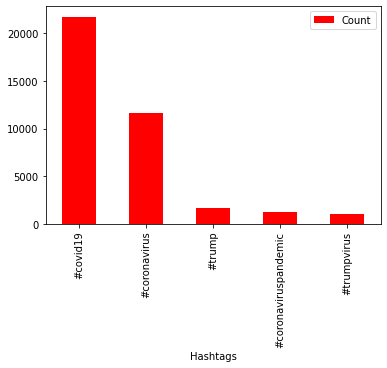

In [ ]:
Hashtags = ["#covid19", "#coronavirus", "#trump", "#coronaviruspandemic", "#trumpvirus"]
Count = [21736, 11638, 1648, 1193, 1077]

df = pd.DataFrame({'Count': Count, "Hashtags": Hashtags})
df.plot(kind='bar',x='Hashtags',y='Count',color='red')
plt.show()

In [ ]:
len(non_hash.most_common())

21317

In [ ]:
df4 = pred[(pred['Predicted'] == 1)]
hashtag_rumour = pd.DataFrame(df4["hashtag"])
hashtag_rumour.dropna(axis=0, inplace=True)
hashtag_rumour.head()

,hashtag
7,[]
16,"[#trump, #coronavirus, #covid19, #covid19, #tr..."
45,"[#chinesecoronavirus, #covid19, #coronaviruspa..."
48,[#fakenews]
72,"[#nepotismbarbie, #trumpdeathtoll120k, #trumpo..."


In [ ]:
hashtag_ru = hashtag_rumour["hashtag"].tolist()
hashtag_ru = [x for x in hashtag_ru if len(x)!=0]
hashtag_ru = [each for x in hashtag_ru for each in x]
hashtag_ru[:10]

['#trump',
 '#coronavirus',
 '#covid19',
 '#covid19',
 '#trumpisalaughingstock',
 '#fakegate',
 '#covid19',
 '#america',
 '#coronavirus',
 '#stayathome']

In [ ]:
len(hashtag_ru)

18145

In [ ]:
ruCounter = Counter(hashtag_ru)
ruCounter.most_common()[:10]

[('#covid19', 3045),
 ('#coronavirus', 1565),
 ('#trump', 267),
 ('#covid19.', 161),
 ('#coronaviruspandemic', 137),
 ('#trumpvirus', 137),
 ('#maga', 127),
 ('#covid_19', 126),
 ('#covidー19', 121),
 ('#covid', 105)]

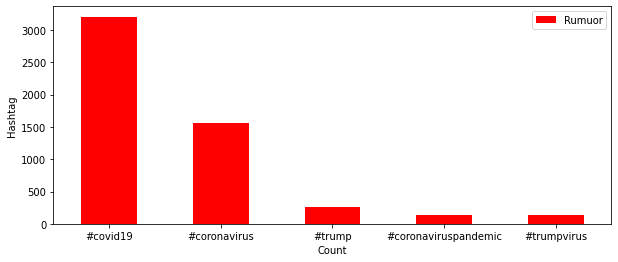

In [ ]:
Hashtags = ["#covid19", "#coronavirus", "#trump", "#coronaviruspandemic", "#trumpvirus"]
Non_rumour = [21736, 11638, 1648, 1193, 1077]
Rumuor = [3206, 1565, 267, 137, 137]

# df = pd.DataFrame({'Non-Rumuour': Non_rumour}, index=Hashtags)
# # df.plot(kind='bar',x='Hashtags',y='Count',color='red')
# df.plot(kind='bar', figsize=(10, 4), rot=0, ylabel='Hashtag', xlabel="Count")
# plt.show()

df = pd.DataFrame({"Rumuor": Rumuor}, index=Hashtags)
# df.plot(kind='bar',x='Hashtags',y='Count',color='red')
df.plot(kind='bar', figsize=(10, 4), rot=0, ylabel='Hashtag', xlabel="Count", color='red')
plt.show()

In [ ]:
print(len(ruCounter.most_common()))

5357


In [ ]:
hashtag_share = pd.DataFrame(pred["hashtag"])
hashtag_share.dropna(axis=0, inplace=True)
hashtag_share.head()

,hashtag
0,[#tenet]
1,[]
2,[]
3,[]
4,"[#coronavirus, #lovehurts, #magarally, #tulsa,..."


In [ ]:
hashtag_share = hashtag_share["hashtag"].tolist()
hashtag_share = [x for x in hashtag_share if len(x)!=0]
hashtag_share = [each for x in hashtag_share for each in x]
hashtag_share[:10]

['#tenet',
 '#coronavirus',
 '#lovehurts',
 '#magarally',
 '#tulsa',
 '#coronavirus',
 '#covid19',
 '#coronavirus',
 '#coronapalooza',
 '#coronavirus?”']

In [ ]:
sCounter = Counter(hashtag_share)
sCounter.most_common()[:10]

[('#covid19', 23615),
 ('#coronavirus', 13203),
 ('#trump', 1915),
 ('#covid19.', 1354),
 ('#coronaviruspandemic', 1214),
 ('#trumpvirus', 1082),
 ('#covid_19', 944),
 ('#covidー19', 851),
 ('#wuhanvirus', 833),
 ('#maga', 764)]

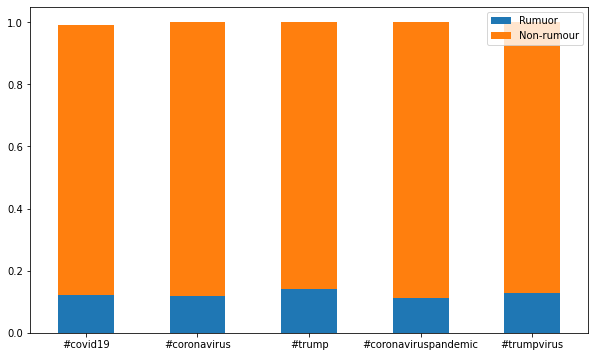

In [ ]:
Hashtags = ["#covid19", "#coronavirus", "#trump", "#coronaviruspandemic", "#trumpvirus"]
Non_rumour = [21736/24969, 11638/13203, 1648/1915, 1077/1214, 945/1082]
Rumuor = [3026/24969, 1565/13203, 267/1915, 137/1214, 137/1082]
# Share = [24969, 13203, 1915,1214,  1082]

df = pd.DataFrame({"Rumuor": Rumuor, "Non-rumour": Non_rumour}, index=Hashtags)
df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
# df.plot(kind='bar',x='Hashtags',y='Count',color='red')
# df.plot(kind='bar', figsize=(10, 4), rot=0, ylabel='Hashtag', xlabel="Count", color='red')
plt.show()

In [ ]:
len(sCounter.most_common())

23615

In [ ]:
non_keys = [k for (k, c) in non_hash.most_common()]
ru_keys =[k for (k, c) in ruCounter.most_common()]
non_share = [(h, c) for (h, c) in sCounter.most_common() if (h not in non_keys) & (h not in ru_keys)]
non_share

[]

# Number of Replies Analysis

In [ ]:
f = open(f'./covid_text.pckl','rb')
covid_data = pickle.load(f)
f.close()

In [ ]:
num_re = []
for each in covid_data:
  num_re.append(len(each)-1)
print(len(num_re))

17458


In [ ]:
covid_df = pd.DataFrame({'text':covid_merge_events, 'hashtag':covid_merge_hashtag, 'num replies': num_re})
nan_value = float("NaN")
covid_df.replace("", nan_value, inplace=True)
covid_df.dropna(axis=0 ,inplace=True)
covid_df.reset_index()

,index,text,hashtag,num replies
0,0,according to the new york times warner bros wa...,[#tenet],0
1,1,hurricane hanna has made landfall in texas the...,[],1
2,2,monkeys on the loose in india with stolen coro...,[],0
3,3,let s not play blind that the work is fighting...,[],2
4,4,if trump felt comfortable having it here then ...,"[#coronavirus, #lovehurts, #magarally, #tulsa,...",22
...,...,...,...,...
17007,17453,i wonder how many lives could ve been saved if...,"[#cheaterinchief, #covid19]",7
17008,17454,the front page on th march the first line read...,"[#farright, #fakenews, #toriesout, #johnsonmus...",62
17009,17455,trump just completed the racism trifecta in a ...,[],1
17010,17456,here are a few of my photographs from today s ...,"[#covid19, #voting, #parliament]",1


In [ ]:
pred["text"] = covid_df["text"]
pred["hashtag"] = covid_df["hashtag"]
pred["num replies"] = covid_df["num replies"]

In [ ]:
non = pred[(pred['Predicted'] == 0)]["num replies"].tolist()
ru = pred[(pred['Predicted'] == 1)]["num replies"].tolist()

In [ ]:
import math
non = [x for x in non if math.isnan(x) == False]
ru = [x for x in ru if math.isnan(x) == False]

In [ ]:
total_non = len(non)
total_re = len(ru)

In [ ]:
print(total_non)
print(total_re)

14538
2045


In [ ]:
non_num = Counter(non)
ru_num = Counter(ru)

In [ ]:
non_num.most_common()[:100]

[(0.0, 3624),
 (1.0, 2464),
 (2.0, 1615),
 (3.0, 1148),
 (4.0, 763),
 (5.0, 578),
 (6.0, 425),
 (7.0, 290),
 (8.0, 276),
 (9.0, 233),
 (10.0, 164),
 (11.0, 143),
 (18.0, 139),
 (16.0, 134),
 (15.0, 134),
 (17.0, 132),
 (19.0, 124),
 (13.0, 123),
 (12.0, 113),
 (20.0, 112),
 (14.0, 108),
 (21.0, 101),
 (25.0, 89),
 (23.0, 86),
 (24.0, 81),
 (26.0, 79),
 (22.0, 76),
 (28.0, 62),
 (27.0, 57),
 (29.0, 48),
 (32.0, 40),
 (31.0, 38),
 (35.0, 35),
 (36.0, 29),
 (33.0, 27),
 (34.0, 27),
 (37.0, 26),
 (30.0, 26),
 (39.0, 24),
 (38.0, 24),
 (44.0, 21),
 (40.0, 19),
 (45.0, 17),
 (41.0, 16),
 (50.0, 15),
 (49.0, 15),
 (61.0, 14),
 (57.0, 14),
 (52.0, 14),
 (46.0, 14),
 (42.0, 13),
 (47.0, 12),
 (51.0, 12),
 (43.0, 11),
 (59.0, 11),
 (48.0, 10),
 (55.0, 9),
 (58.0, 9),
 (84.0, 9),
 (63.0, 9),
 (53.0, 8),
 (70.0, 8),
 (81.0, 8),
 (69.0, 7),
 (87.0, 7),
 (76.0, 7),
 (67.0, 7),
 (93.0, 7),
 (94.0, 7),
 (60.0, 7),
 (85.0, 6),
 (88.0, 6),
 (68.0, 6),
 (75.0, 6),
 (90.0, 6),
 (74.0, 5),
 (79.0, 5),
 (10

In [ ]:
les_10_non = sum([c for (numre,c) in non_num.most_common() if numre <= 10])
les_10_non

11580

In [ ]:
les_20_non = sum([c for (numre,c) in non_num.most_common() if numre <= 20])
les_20_non

12842

In [ ]:
more_20_non = sum([c for (numre,c) in non_num.most_common() if numre > 20])
more_20_non

1696

In [ ]:
les_10_ru = sum([c for (numre,c) in ru_num.most_common() if numre <= 10])
les_10_ru

1607

In [ ]:
les_20_ru = sum([c for (numre,c) in ru_num.most_common() if numre <= 20])
les_20_ru

1790

In [ ]:
more_20_ru = sum([c for (numre,c) in ru_num.most_common() if numre > 20])
more_20_ru

255

In [ ]:
print(les_10_non/total_non)
print(les_20_non/total_non)
print(more_20_non/total_non)

0.7965332232769294
0.8833402118585775
0.11665978814142249


In [ ]:
print(les_10_ru/total_re)
print(les_20_ru/total_re)
print(more_20_ru/total_re)

0.7858190709046454
0.8753056234718827
0.12469437652811736


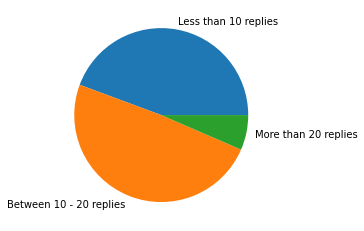

In [ ]:
y = [les_10_non, les_20_non, more_20_non]
mylabels = ["Less than 10 replies", "Between 10 - 20 replies", "More than 20 replies"]

plt.pie(y, labels = mylabels)
plt.show() 

TypeError: ignored

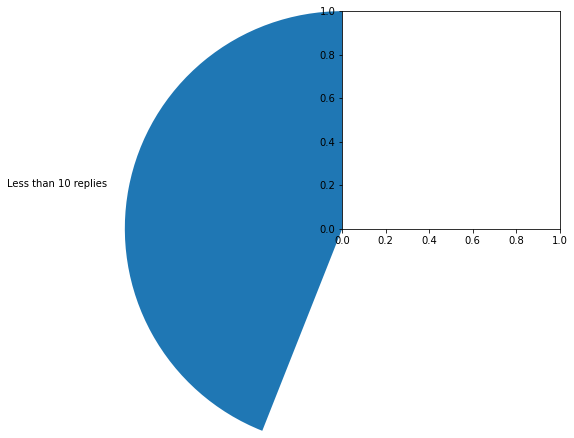

In [ ]:
y = [les_10_ru, les_20_ru, more_20_ru]
mylabels = ["Less than 10 replies", "Between 10 - 20 replies", "More than 20 replies"]

plt.pie(y, labels = mylabels, startangle = 90)
plt.show() 

In [ ]:
# train labels
train_label_file = open('./train.label.txt', 'r') 
train_labels = train_label_file.readlines()
train_labels = [label.strip('\n') for label in train_labels]

#dev labels
dev_label_file = open('./dev.label.txt', 'r')
dev_labels = dev_label_file.readlines()
dev_labels = [label.strip('\n') for label in dev_labels]

In [ ]:
tCounter = Counter(train_labels)
devCounter = Counter(dev_labels)

In [ ]:
tCounter

Counter({'nonrumour': 1475, 'rumour': 420})

In [ ]:
devCounter

Counter({'nonrumour': 493, 'rumour': 139})

# Length text analysis

In [ ]:
# train tweets
f = open(f'./tweet_text.pckl','rb')
train_data = pickle.load(f)
f.close()

# dev tweets
f = open(f'./dev_tweet_text.pckl','rb')
dev_data = pickle.load(f)
f.close()

In [ ]:
## cleaning the tweets
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #remove @mention
    text = re.sub(r'#','',text) # remove the hashtag symbol
    text = re.sub(r'https?:\/\/\S+', '',text) #remove hyperlink
    text = re.sub(r'\n','',text) # remove \n 
    text = re.sub(r'\r','',text) # remove \r
    text = re.sub(r'[0-9]+','',text) #remove all the number
    text = re.sub(r'\W+', ' ', text) #remove special characters
    text = text.strip().lower()
    if len(text) != 0:
        return text
    else:
        return None

In [ ]:
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        train_data[i][j] = clean_text(train_data[i][j])
    train_data[i] = [x for x in train_data[i] if x is not None]
        
for i in range(len(dev_data)):
    for j in range(len(dev_data[i])):
        dev_data[i][j] = clean_text(dev_data[i][j])
    dev_data[i] = [x for x in dev_data[i] if x is not None]

In [ ]:
train_len = []
dev_len = []
for events in train_data:
  merge = ' '.join(word for word in events)
  split = merge.split(" ")
  train_len.append(len(split))

for events in dev_data:
  merge = ' '.join(word for word in events)
  split = merge.split(" ")
  dev_len.append(len(split))

In [ ]:
t_Counter = Counter(train_len)
d_Counter = Counter(dev_len)

In [ ]:
les_512_t = sum([c for (len,c) in t_Counter.most_common() if len < 512])
more_512_t = sum([c for (len,c) in t_Counter.most_common() if len >= 512])
print(les_512_t)
print(more_512_t)

1766
129


In [ ]:
more_512_tl = [(len, c) for (len,c) in t_Counter.most_common() if len >= 612]

In [ ]:
les_512_d = sum([c for (len,c) in d_Counter.most_common() if len < 512])
more_512_d = sum([c for (len,c) in d_Counter.most_common() if len >= 512])
print(les_512_d)
print(more_512_d)

590
42
